In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [2]:
N = 2; k_B = 1; temp = 1e2; temp_ref = 1e0
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]

### construcción de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]
ts = np.linspace(0, 50,700)  

### Heisenberg Hamiltonian & classical operators
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

### Base completa

zero_body_ops = spin_ops_list[0]
one_body_ops = [op for op in spin_ops_list[1]+spin_ops_list[2]+spin_ops_list[3]]
two_body_ops = [op1 * op2 for op1 in one_body_ops for op2 in one_body_ops]
depth_and_seed_ops = [(1,op) for op in (zero_body_ops+one_body_ops+two_body_ops)]
print(len(depth_and_seed_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]
43


In [4]:
depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                      (1, H_H), 
                      (3, cl_ops["magnetization"])]
coeff_list = [0., .5, .25, .125, .125]

observables = list(cl_ops.values())
Gram_matrix, init_configs_mg, dict_res_proj_ev, res_exact = me.d_depth_proj_ev(
    temp_ref = temp_ref, temp_rho = temp, timespan = ts, 
    Hamiltonian = H_H, lagrange_op = cl_ops["n_oc_disp"],
    depth_and_seed_ops = depth_and_seed_ops, observables = observables, 
    label_ops = label_ops, coeff_list = coeff_list, 
    visualize_H_evs = False, visualization_nonherm = False, visualize_expt_vals = False
)

using a base of size  5
rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.52 0.0 0.0 0.005]
 [0.0 0.451 0.033 0.0]
 [0.0 0.033 0.013000000000000001 0.0]
 [0.005 0.0 0.0 0.013000000000000001]]
The basis is orthonormal and hermitian
rho_0:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.397+0.j     0.   +0.j     0.   +0.j    -0.016-0.022j]
 [ 0.   +0.j     0.564+0.j     0.048+0.j     0.   +0.j   ]
 [ 0.   +0.j     0.048+0.j     0.015+0.j     0.   +0.j   ]
 [-0.016+0.022j  0.   +0.j     0.   +0.j     0.024+0.j   ]]
Proj ev runtime =  3.594648838043213
Exact ev runtime =  0.0980539321899414


using a base of size  6
rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.52 0.0 0.0 0.005]
 [0.0 0.451 0.033 0.0]
 [0.0 0.033 0.013000000000000001 0.0]
 [0.005 0.0 0.0 0.013000000000000001]]
The basis is orthonormal and hermitian
rho_0:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.346+0.j     0.   +0.j     0.   +0.j    -0.004+0.025j]
 [ 0.   +0.j     0.603+0.j    -0.055+0.112j  0.   +0.j   ]
 [ 0.   +0.j    -0.055-0.112j  0.041+0.j     0.   +0.j   ]
 [-0.004-0.025j  0.   +0.j     0.   +0.j     0.01 +0.j   ]]
Proj ev runtime =  4.320991039276123
Exact ev runtime =  0.08408832550048828


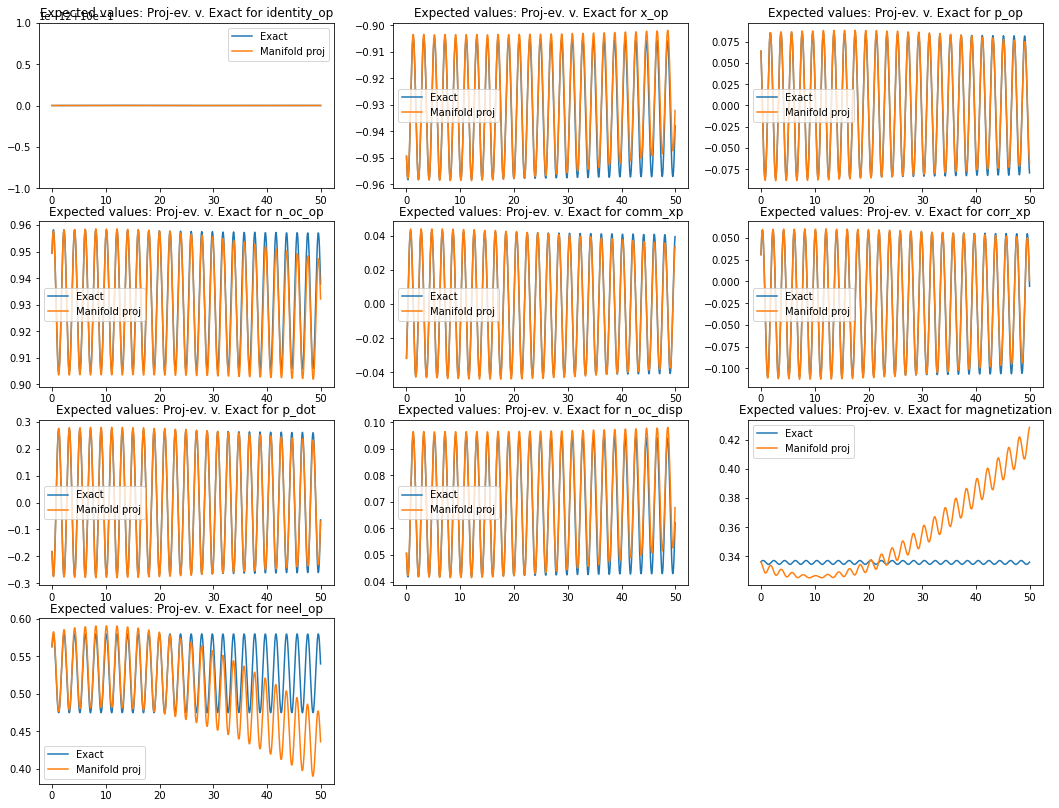

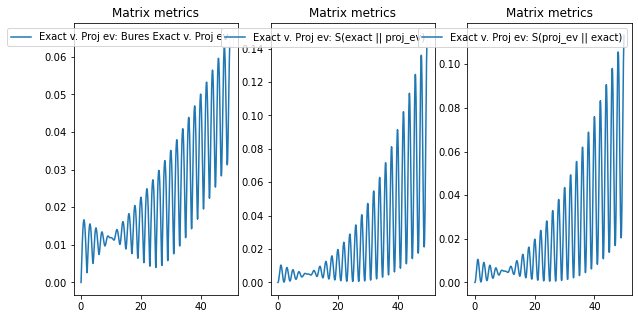

In [20]:
depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                      (1, H_H), 
                      (4, cl_ops["x_op"])]
coeff_list = [0., .5, .5, .5, .125, .125]

observables = list(cl_ops.values())
Gram_matrix, init_configs_xop, dict_res_proj_ev, res_exact = me.d_depth_proj_ev(
    temp_ref = temp_ref, temp_rho = temp, timespan = ts, 
    Hamiltonian = H_H, lagrange_op = cl_ops["n_oc_disp"],
    depth_and_seed_ops = depth_and_seed_ops, observables = observables, 
    label_ops = label_ops, coeff_list = coeff_list, 
    visualize_H_evs = False, visualization_nonherm = False, visualize_expt_vals = True
)

In [21]:
cohr_list, coherence = me.mutual_coherence(init_configs_mg["basis orth"], init_configs_xop["basis orth"],
                    init_configs_mg["rho_ref"], me.HS_inner_prod_r)
cohr_list

[1.0,
 -2.220446049250313e-16,
 7.632783294297951e-17,
 0.0,
 3.3306690738754696e-16,
 0.0,
 1.3877787807814457e-16,
 0.999999999999999,
 1.5126788710517758e-15,
 0.0,
 6.328271240363392e-15,
 0.0,
 3.469446951953614e-18,
 9.020562075079397e-16,
 0.9999999999999999,
 0.0,
 -1.304512053934559e-15,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 -1.165387231161219e-14,
 -1.3183898417423734e-16,
 3.4139358007223564e-15,
 4.2327252813834093e-16,
 0.0,
 0.9999999999999996,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0939166239509746e-14,
 0.0,
 1.0]

In [28]:
v1 = H_H.eigenstates()[1][1]
Projectors = [v1 * v1.dag() for v1 in H_H.eigenstates()[1]]

In [32]:
Projectors[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.999 0.0 0.0 0.012]
 [0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0]
 [0.012 0.0 0.0 0.0]]

In [41]:
depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                      (1, H_H), 
                      (8, cl_ops["magnetization"])]

K_ref, rho_ref = me.build_reference_state(temp = temp_ref, 
                                              Hamiltonian = H_H,
                                              lagrange_op = cl_ops["n_oc_disp"], 
                                              lagrange_mult = .5)
    
basis_incursive = me.vectorized_recursive_basis(depth_and_ops=depth_and_seed_ops,                                             
                                                    Hamiltonian=H_H, 
                                                    rho0=rho_ref)
    
basis_orth = me.base_orth(ops = basis_incursive, 
                              rho0 = rho_ref, 
                              sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)

In [42]:
len(basis_orth) ### esta se cierra con 3 conmutadores

5

In [45]:
depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                      (1, H_H), 
                      (16, cl_ops["x_op"])]

K_ref, rho_ref = me.build_reference_state(temp = temp_ref, 
                                              Hamiltonian = H_H,
                                              lagrange_op = cl_ops["n_oc_disp"], 
                                              lagrange_mult = .5)
    
basis_incursive = me.vectorized_recursive_basis(depth_and_ops=depth_and_seed_ops,                                             
                                                    Hamiltonian=H_H, 
                                                    rho0=rho_ref)
    
basis_orth = me.base_orth(ops = basis_incursive, 
                              rho0 = rho_ref, 
                              sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)
len(basis_orth) ### esta se cierra en 5 conmutadores

7